# PyTorch 深度学习 - DNN
目标：熟悉 PyTorch 代码，能够看懂网上论文的代码，便于复现。
## 张量
数组与张量的联系和区别在 NumPy 库的知识中已经讲过，这里不再赘述。

In [1]:
# 防止 Jupyter 内核挂掉
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# 查看设备的GPU方法
! nvidia-smi

Sun Mar 31 15:05:52 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX350      WDDM  | 00000000:2D:00.0 Off |                  N/A |
| N/A   43C    P8    N/A /  N/A |     68MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
import torch
# 默认的张量存储在CPU上
ts1 = torch.randn(3, 4)
print(ts1)
# 移动到GPU上
ts2 = ts1.to('cuda:0')
print(ts2)

tensor([[ 0.3981,  0.1936, -0.0166,  0.5714],
        [ 1.5311, -0.4334, -0.8395,  1.4460],
        [-0.4787, -0.2815,  0.9048,  1.5041]])
tensor([[ 0.3981,  0.1936, -0.0166,  0.5714],
        [ 1.5311, -0.4334, -0.8395,  1.4460],
        [-0.4787, -0.2815,  0.9048,  1.5041]], device='cuda:0')


以上操作可以把数据集放到 GPU 上，但是我们的神经网络模型也要放到 GPU 上才能正常运行。

## DNN 的原理
神经网络通过学习大量样本的输入与输出特征之间的关系，以拟合出输入和输出之间的方程，学习完成后，只给他输入特征，他便可以给出输出特征。神经网络可以分为这么几步：划分数据集，训练网络，测试网络，使用网络。

理论部分这里不再总结，可以自行去看专门的深度学习书籍，如李沐老师的[《动手学深度学习》](https://zh.d2l.ai/index.html)。

## DNN 的实现
torch.nn 提供了搭建神经网络的所有组件，nn 即 Neural Network 神经网络。因此可以单独给 torch.nn 一个别名，即 import torch.nn as nn。

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

### 制作数据集
在训练之前，我们要准备好训练集的样本。

In [5]:
# 生成数据集
X1 = torch.rand(10000, 1)
X2 = torch.rand(10000, 1)
X3 = torch.rand(10000, 1)

Y1 = ((X1 + X2 + X3) < 1).float()
Y2 = ((1 < (X1 + X2 + X3)) & ((X1 + X2 + X3) < 2)).float()
Y3 = ((X1 + X2 + X3) > 2).float()
Data = torch.cat([X1, X2, X3, Y1, Y2, Y3], axis=1)
Data = Data.to('cuda:0')
Data

tensor([[0.1150, 0.3532, 0.8855, 0.0000, 1.0000, 0.0000],
        [0.6191, 0.6390, 0.0506, 0.0000, 1.0000, 0.0000],
        [0.0333, 0.6250, 0.3088, 1.0000, 0.0000, 0.0000],
        ...,
        [0.2897, 0.4866, 0.7116, 0.0000, 1.0000, 0.0000],
        [0.3280, 0.9015, 0.6366, 0.0000, 1.0000, 0.0000],
        [0.3087, 0.8724, 0.6568, 0.0000, 1.0000, 0.0000]], device='cuda:0')

In [6]:
# 划分训练集与测试集
train_size = int(len(Data) * 0.7)
test_size = len(Data) - train_size
Data = Data[torch.randperm(Data.size(0)), :] # 打乱样本的顺序
train_Data = Data[:train_size, :] # 训练集样本
test_Data = Data[train_size:, :] # 测试集样本
train_Data.shape, test_Data.shape

(torch.Size([7000, 6]), torch.Size([3000, 6]))

### 搭建神经网络
搭建神经网络时，以 nn.Module 作为父类，我们自己的神经网络可直接继承父类的方法与属性，nn.Module 中包含网络各个层的定义。

在定义神经网络子类中，通常包含__init__特殊方法和 forward 方法。__init__特殊方法用于构造自己的神经网络结构，forward 方法用于将输入数据进行前向传播。由于张量可以自动计算梯度，所以不需要出现反向传播算法。

In [7]:
class DNN(nn.Module):
    def __init__(self):
        '''搭建神经网络各层'''
        super(DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 5), nn.ReLU(),
            nn.Linear(5, 5), nn.ReLU(),
            nn.Linear(5, 5), nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        '''前向传播'''
        y = self.net(x)
        return y
    
model = DNN().to('cuda:0')
model

DNN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)

### 神经网络的内部参数
神经网络的内部参数是权重与偏置，内部参数在神经网络训练之前会被赋予随机数，随着训练的进行，内部参数会逐渐迭代至最佳值，先对参数进行查看。

In [8]:
# 查看内部参数
for name, param in model.named_parameters():
    print(f"参数：{name}\n形状：{param.shape}\n数值：{param}\n")

参数：net.0.weight
形状：torch.Size([5, 3])
数值：Parameter containing:
tensor([[ 0.5252,  0.2653, -0.4478],
        [ 0.2518, -0.3664, -0.2945],
        [-0.2610,  0.5066,  0.0800],
        [-0.1553, -0.3998,  0.1035],
        [-0.0669,  0.3177,  0.2928]], device='cuda:0', requires_grad=True)

参数：net.0.bias
形状：torch.Size([5])
数值：Parameter containing:
tensor([ 0.0853,  0.3303,  0.2247,  0.5394, -0.2733], device='cuda:0',
       requires_grad=True)

参数：net.2.weight
形状：torch.Size([5, 5])
数值：Parameter containing:
tensor([[-0.4087, -0.2694,  0.0294,  0.2357,  0.0594],
        [-0.0584, -0.4376, -0.0047, -0.3112, -0.3024],
        [ 0.3085,  0.2702,  0.1322,  0.3918,  0.0560],
        [-0.1450, -0.1089, -0.1086, -0.0619,  0.3120],
        [ 0.4354, -0.0052, -0.2172,  0.2025, -0.0897]], device='cuda:0',
       requires_grad=True)

参数：net.2.bias
形状：torch.Size([5])
数值：Parameter containing:
tensor([ 0.3094,  0.2219,  0.2564,  0.3344, -0.3484], device='cuda:0',
       requires_grad=True)

参数：net.4.weight

根据以上对神经网络的内部参数总结几点：
- 首先，net.0.weight 的权重形状为 (5, 3)，5 表示它自己的节点数是 5，3 表示与之连接的前一层的节点数是 3；

- 其次，由于上面的代码块中进行了 model = DNN().to('cuda:0') 操作，因此所有的内部参数都自带 device = 'cuda:0'；

- 最后，注意到 requires_grad = True，说明所有需要进行反向传播的内部参数（即权重与偏置）都打开了张量自带的梯度计算功能。

### 网络的外部参数
外部参数即**超参数**，这是调参时关注的重点。下面列举一些常用参数，具体可见[PyTorch官方文档](https://pytorch.org/docs/stable/nn.html)。
- 搭建网络的超参数有：网络层数，各隐藏层节点数，各节点激活函数，内部参数的初始值等；

- 训练网络的超参数有：损失函数，学习率，优化算法，batch_size，epochs等。

### 训练网络

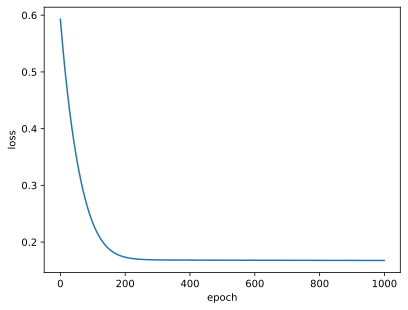

In [9]:
# 损失函数的选择
loss_fn = nn.MSELoss()

# 优化算法的选择
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 训练网络
epochs = 1000
losses = []

# 给训练集划分输入和输出
X = train_Data[:, :3] # 前3列为输入特征
Y = train_Data[:, -3:] # 后3列为输出特征

for epoch in range(epochs):
    pred = model(X)             # 一次前向传播
    loss = loss_fn(pred, Y)     # 计算损失函数
    losses.append(loss.item())  # 记录损失函数的变化 
    optimizer.zero_grad()       # 清理上一轮滞留的梯度
    loss.backward()             # 一次反向传播
    optimizer.step()            # 优化内部参数

Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 测试网络
测试时，只需要让测试集进行 1 次前向传播即可，这个过程不需要计算梯度，因此可以在该局部关闭梯度，该操作使用 with torch.no_grad(): 命令。

In [12]:
X = train_Data[:, :3] # 前3列为输入特征
Y = train_Data[:, -3:] # 后3列为输出特征

# 该局部关闭梯度计算功能
with torch.no_grad():
    pred = model(X)
    pred[:, torch.argmax(pred, axis=1)] = 1 # 将预测概率最大的设为1
    pred[pred != 1] = 0 # 其他预测值设为0
    correct = torch.sum((pred == Y).all(1)) # 统计预测正确的样本数量
    total = Y.size(0)
    print(f"测试集准确度：{100 * correct / total}%") 

测试集准确度：66.32856750488281%
